In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import yfinance
from datetime import datetime
from datetime import date

#### Black Scholes Function for Option Price Prediction

In [4]:
def price(S,K,r,t,sigma, call = True):
    d1 = (np.log(S/K) + (r +.5*sigma**2)*t)/(sigma * np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)

    Put_price = S * norm.cdf(d1,0,1) - K * np.exp(-r*t)*norm.cdf(d2,0,1)
    Call_price = K * np.exp(-r*t)* norm.cdf(-d2,0,1) - S*norm.cdf(-d1,0,1)
    if call == True:
        return Call_price
    else:
        return Put_price

#### Example Variables for Black Scholes Pricing

In [39]:
stock = "SPY"
stock_price = yfinance.Ticker(stock).history(period="1y")['Close'][-1]
K = 400
r = yfinance.Ticker("^TNX").history(period="1y")['Close'][-1] / 100

dates = yfinance.Ticker("SPY").options
fut_date = '2023-12-15'

#### Cleaning Price Data
I made it easier to select put and call prices for a given expiration date.

In [41]:
import re
chain = yfinance.Ticker("SPY").option_chain(fut_date)
len(chain)

chains = list()
for i in np.arange(len(chain)):
    chains.append(chain[i])
res_chains = pd.concat(chains)
string = res_chains[res_chains["strike"] == K]["contractSymbol"].iloc[1]
symbols = res_chains["contractSymbol"]

def ret_type(symbol,ticker):
    string1 = symbol.strip(ticker)
    string1 = re.sub(r'[0-9]', '', string1)
    return string1
ret_type(string, "SPY")

symbols1 = [ret_type(x,"SPY") for x in symbols]
symbols1
res_chains["symbols"] = [ret_type(x,"SPY") for x in symbols]
real = res_chains[res_chains["symbols"] == "P"]["lastPrice"]
prices1 = res_chains[res_chains["symbols"] == "P"]["strike"]

#### Graph of the Pricing Model and Market Prices Comparison

94    0.254097
Name: impliedVolatility, dtype: float64
Black Scholes Price = $11.31
market value = $6.51


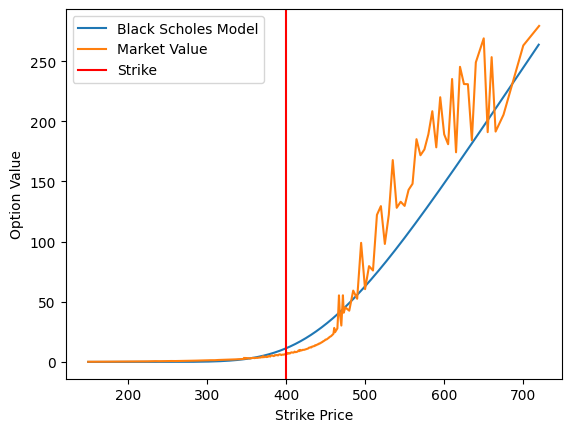

In [42]:
imp_sigma = np.max(res_chains[(res_chains["strike"] == K)]["impliedVolatility"])
print(res_chains[(res_chains["strike"] == K) & (res_chains["symbols"] == "C")]["impliedVolatility"])
date_today = datetime(date.today().year, date.today().month, date.today().day)
fut_datetime = datetime.strptime(fut_date,'%Y-%m-%d')
diff = fut_datetime - date_today
t = diff.days/365

prices = np.arange(np.min(prices1),np.max(prices1),.5)

call_price_array = np.array([price(stock_price,pr,r,t,imp_sigma, call = True) for pr in prices])

plt.plot(prices, call_price_array, label = "Black Scholes Model")
plt.plot(prices1,real, label = "Market Value")
plt.axvline(K, color = "red", label = "Strike")
plt.xlabel("Strike Price")
plt.ylabel("Option Value")
plt.legend()

index = np.where(prices == K)
index1 = np.where(prices1 == K)

print(f"Black Scholes Price = ${np.round(call_price_array[index][0],2)}")
print(f"market value = ${real.iloc[index1].values[0]}")